In [1]:
import json
import os
from pathlib import Path
import sys
import time

import joblib
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.metrics
import sklearn.model_selection
from tqdm.auto import tqdm

os.chdir(str(Path.cwd().parents[0]))
import src

X, y, s = src.get_Xys()
y = y>0
ys = y + 3*s

cache_dir = 'cache/modelB'

skf = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)
outer_folds = list(enumerate(skf.split(X=X, y=ys)))
# E.g. for train_idx, val_idx in inner_folds:
#           X[train_idx]...
inner_folds = [
    ((outer_idx, inner_idx), (trainval_idx[train_idx], trainval_idx[val_idx]))
    for outer_idx, (trainval_idx, _) in outer_folds
    for inner_idx, (train_idx, val_idx)
    in enumerate(skf.split(X=X[trainval_idx], y=ys[trainval_idx]))
]
params = [
    (int(max_depth), int(n_bins), float(orthogonality))
    for n_bins in (2,)
    for max_depth in np.arange(1, 11) 
    for orthogonality in np.linspace(0, 1, 11)
]

# Learn on every outer fold

In [2]:
iterations = [
    (max_depth, n_bins, orthogonality, fold, trainval_idx, test_idx)
    for max_depth, n_bins, orthogonality in params
    for fold, (trainval_idx, test_idx) in outer_folds
]
print(f"Number of iterations: {len(iterations)}")

for max_depth, n_bins, ortho, fold, trainval_idx, test_idx in tqdm(iterations):
    filepath = f'{cache_dir}/{max_depth}-{ortho:.2f}-{n_bins}-{fold}.pkl'
    if os.path.isfile(filepath):
        continue
    X_trainval = X[trainval_idx]
    y_trainval = y[trainval_idx]
    s_trainval = s[trainval_idx]
    
    vt = sklearn.feature_selection.VarianceThreshold()
    vt.fit(X_trainval)
    X_trainval = vt.transform(X_trainval)
    
    clf = src.FairRandomForestClassifier(n_estimators=100, 
                                         n_jobs=100, 
                                         orthogonality=ortho,
                                         max_depth=max_depth,
                                         n_bins=n_bins)
    start_fit = time.time()
    clf.fit(X_trainval, y_trainval, s_trainval)
    clf.fit_time = time.time() - start_fit
    joblib.dump(clf, filepath)

Number of iterations: 550


  0%|          | 0/550 [00:00<?, ?it/s]

# Learn on every inner fold

In [3]:
iterations = [
    (max_depth, n_bins, orthogonality, outer_fold, inner_fold, 
     train_idx, val_idx)
    for max_depth, n_bins, orthogonality in params
    for (outer_fold, inner_fold), (train_idx, val_idx) in inner_folds
    if not os.path.isfile(f'{cache_dir}/{max_depth}-{ortho:.2f}-{n_bins}-{outer_fold}-{inner_fold}.pkl')
]
print(f"Number of iterations: {len(iterations)}")

for max_depth, n_bins, ortho, outer_fold, inner_fold, train_idx, val_idx in tqdm(iterations):
    filepath = f'{cache_dir}/{max_depth}-{ortho:.2f}-{n_bins}-{outer_fold}-{inner_fold}.pkl'
    X_train = X[train_idx]
    y_train = y[train_idx]
    s_train = s[train_idx]
    vt = sklearn.feature_selection.VarianceThreshold()
    vt.fit(X_train)
    X_train = vt.transform(X_train)
    clf = src.FairRandomForestClassifier(n_estimators=100, 
                                         n_jobs=100, 
                                         orthogonality=ortho,
                                         max_depth=max_depth,
                                         n_bins=n_bins)
    start_fit = time.time()
    clf.fit(X_train, y_train, s_train)
    clf.fit_time = time.time() - start_fit
    joblib.dump(clf, filepath)

Number of iterations: 0


0it [00:00, ?it/s]

# Predict on all outer folds

In [4]:
iterations = [
    (max_depth, n_bins, orthogonality, fold, trainval_idx, test_idx)
    for max_depth, n_bins, orthogonality in params
    for fold, (trainval_idx, test_idx) in outer_folds
]
print(f"Number of iterations: {len(iterations)}")

for max_depth, n_bins, ortho, fold, trainval_idx, test_idx in tqdm(iterations):
    filepath = f'{cache_dir}/{max_depth}-{ortho:.2f}-{n_bins}-{fold}'
    if os.path.isfile(f'{filepath}.npy'):
        continue
    
    X_trainval = X[trainval_idx]
    X_test = X[test_idx]
    
    vt = sklearn.feature_selection.VarianceThreshold()
    vt.fit(X_trainval)
    X_trainval = vt.transform(X_trainval)
    X_test = vt.transform(X_test)
    
    clf = joblib.load(f'{filepath}.pkl')
    y_score = clf.predict_proba(X_test)[:,1]
    np.save(f'{filepath}.npy', y_score)

Number of iterations: 550


  0%|          | 0/550 [00:00<?, ?it/s]

# Predict on all inner folds

In [5]:
iterations = [
    (max_depth, n_bins, orthogonality, outer_fold, inner_fold, 
     train_idx, val_idx)
    for max_depth, n_bins, orthogonality in params
    for (outer_fold, inner_fold), (train_idx, val_idx) in inner_folds
]
print(f"Number of iterations: {len(iterations)}")

for max_depth, n_bins, ortho, outer_fold, inner_fold, train_idx, val_idx in tqdm(iterations):
    filepath = f'{cache_dir}/{max_depth}-{ortho:.2f}-{n_bins}-{outer_fold}-{inner_fold}'
    if os.path.isfile(f'{filepath}.npy'):
        continue
    X_train = X[train_idx]
    X_val = X[val_idx]
    
    vt = sklearn.feature_selection.VarianceThreshold()
    vt.fit(X_train)
    X_train = vt.transform(X_train)
    X_val = vt.transform(X_val)
    
    clf = joblib.load(f'{filepath}.pkl')
    y_score = clf.predict_proba(X_val)[:,1]
    np.save(f'{filepath}.npy', y_score)

Number of iterations: 2750


  0%|          | 0/2750 [00:00<?, ?it/s]

# Measure performance for every outer loop

In [6]:
iterations = [
    (max_depth, n_bins, orthogonality, outer_fold, inner_fold, 
     train_idx, val_idx)
    for max_depth, n_bins, orthogonality in params
    for (outer_fold, inner_fold), (train_idx, val_idx) in inner_folds
]
print(f"Number of iterations: {len(iterations)}")

performance_all_candidates = list()
for max_depth, n_bins, ortho, outer_fold, inner_fold, train_idx, val_idx in tqdm(iterations):
    filepath = f'{cache_dir}/{max_depth}-{ortho:.2f}-{n_bins}-{outer_fold}-{inner_fold}'
    y_score = np.load(f'{filepath}.npy')
    
    y_val = y[val_idx]
    s_val = s[val_idx]
    auc_y = sklearn.metrics.roc_auc_score(y_val, y_score)
    auc_s = sklearn.metrics.roc_auc_score(s_val, y_score)
    auc_s = max(auc_s, 1-auc_s)
    
    performance_all_candidates.append(
        dict(max_depth=max_depth, n_bins=n_bins, orthogonality=ortho,
             outer_fold=outer_fold, inner_fold=inner_fold, 
             auc_y=auc_y, auc_s=auc_s)
    )

Number of iterations: 2750


  0%|          | 0/2750 [00:00<?, ?it/s]

# Determine best parameters 
Determine for every value of orthogonality and for every outer fold

In [7]:
performance_all_candidates = pd.DataFrame(performance_all_candidates)
best_params = (
    performance_all_candidates
    .groupby(['orthogonality', 'outer_fold', 'max_depth', 'n_bins'], as_index=False)
    .agg({'auc_y': 'mean', 'auc_s': 'mean'})
    .sort_values('auc_y', ascending=False)
    .drop_duplicates(subset=['orthogonality', 'outer_fold'])
    .sort_values(['orthogonality', 'outer_fold'])
    [['orthogonality', 'outer_fold', 'max_depth', 'n_bins']]
)
best_params

,orthogonality,outer_fold,max_depth,n_bins
5,0.0,0,6,2
15,0.0,1,6,2
25,0.0,2,6,2
35,0.0,3,6,2
45,0.0,4,6,2
55,0.1,0,6,2
65,0.1,1,6,2
75,0.1,2,6,2
85,0.1,3,6,2
95,0.1,4,6,2


# Measure total performance

In [8]:
total_performance_before_aggregation = list()
for p in tqdm(list(best_params.itertuples())):
    y_score = np.load(f'{cache_dir}/{p.max_depth}-{p.orthogonality:.2f}-{p.n_bins}-{p.outer_fold}.npy')
    
    _, (_, test_idx) = outer_folds[p.outer_fold]
    y_test = y[test_idx]
    s_test = s[test_idx]
    auc_y = sklearn.metrics.roc_auc_score(y_test, y_score)
    auc_s = sklearn.metrics.roc_auc_score(s_test, y_score)
    auc_s = max(auc_s, 1-auc_s)    
    
    total_performance_before_aggregation.append(
        dict(orthogonality=p.orthogonality, auc_y=auc_y, auc_s=auc_s, 
             fold=p.outer_fold)
    )
total_performance_before_aggregation = pd.DataFrame(total_performance_before_aggregation)
total_performance = (
    total_performance_before_aggregation
    .groupby(['orthogonality'], as_index=False)
    .agg(auc_y=('auc_y', 'mean'), auc_y_std=('auc_y', 'std'),
         auc_s=('auc_s', 'mean'), auc_s_std=('auc_s', 'std'))
)

  0%|          | 0/55 [00:00<?, ?it/s]

In [9]:
total_performance

,orthogonality,auc_y,auc_y_std,auc_s,auc_s_std
0,0.0,0.814402,0.003850,0.626898,0.013815
1,0.1,0.813765,0.003883,0.617525,0.012643
2,0.2,0.812861,0.005782,0.607162,0.013119
3,0.3,0.807987,0.003998,0.597155,0.012933
4,0.4,0.803892,0.006532,0.582603,0.013076
5,0.5,0.801250,0.004161,0.569496,0.010762
6,0.6,0.788647,0.007466,0.552828,0.014602
7,0.7,0.776182,0.008163,0.537640,0.010588
8,0.8,0.766792,0.008514,0.529537,0.011115
9,0.9,0.748119,0.003143,0.524257,0.012370


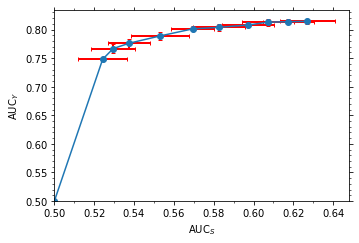

In [10]:
fig, ax = plt.subplots(figsize=(4.82,4.82*(2/3)), constrained_layout=True)
ax.errorbar(data=total_performance,x='auc_s', y='auc_y', xerr='auc_s_std', yerr='auc_y_std', ecolor='red', elinewidth=2, capsize=2, marker='o')
ax.xaxis.set_minor_locator(MultipleLocator(.01))
ax.yaxis.set_minor_locator(MultipleLocator(.01))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_xlim(.5)
ax.set_ylim(.5)
ax.set_xlabel(r'$\mathrm{AUC}_S$')
ax.set_ylabel(r'$\mathrm{AUC}_Y$');
fig.savefig('fig/auc-plot.pdf')

# Determine $\Theta^\ast$

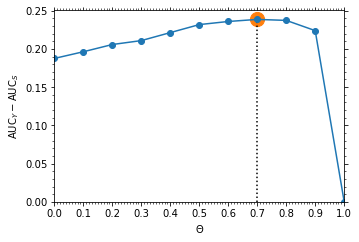

In [11]:
fig, ax = plt.subplots(figsize=(4.82,4.82*(2/3)), constrained_layout=True)
objective = total_performance.auc_y-total_performance.auc_s
idx_star = np.argmax(objective)
ortho_star = total_performance.orthogonality[idx_star]
objective_star = objective.max()
ax.plot(total_performance.orthogonality, objective, marker='o')
ax.scatter(ortho_star, objective_star, marker='o', c='C1', s=200)
ax.vlines(ortho_star, 0, objective_star, color='black', ls=':')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(MultipleLocator(.01))
ax.xaxis.set_major_locator(MultipleLocator(.1))
ax.yaxis.set_minor_locator(MultipleLocator(.01))
ax.set_xlim(0, 1)
ax.set_ylim(0)
ax.set_xlabel(r'$\Theta$')
ax.set_ylabel(r'$\mathrm{AUC}_Y - \mathrm{AUC}_S$')
fig.savefig('fig/objective.pdf')

# Determine $\hat y$ and threshold

In [12]:
iterator = list(best_params.loc[lambda x: x.orthogonality == ortho_star].itertuples())

y_scores_all = list()
y_test_all = list()
s_test_all = list()
for p in tqdm(iterator): 
    y_score = np.load(f'{cache_dir}/{p.max_depth}-{p.orthogonality:.2f}-{p.n_bins}-{p.outer_fold}.npy')
    
    _, (_, test_idx) = outer_folds[p.outer_fold]
    
    y_test = y[test_idx]
    s_test = s[test_idx]
    
    # FLIPPING!!!
    y_scores_all.extend(1-y_score)
    y_test_all.extend(~y_test)
    
    s_test_all.extend(s_test)
    
y_scores_all = np.array(y_scores_all)
y_test_all = np.array(y_test_all)
s_test_all = np.array(s_test_all)

threshold = np.quantile(y_scores_all, np.mean(~y_test_all))
y_pred_all = y_scores_all > threshold

  0%|          | 0/5 [00:00<?, ?it/s]

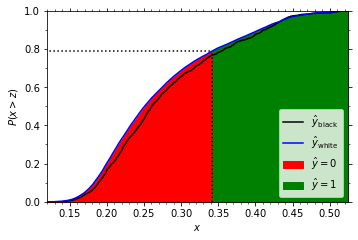

In [13]:
fig, ax = plt.subplots(figsize=(4.82,4.82*(2/3)), constrained_layout=True)
y_scores_sorted = np.sort(y_scores_all)
y1 = 1. * np.arange(len(y_scores_sorted)) / (len(y_scores_sorted) - 1)
y_scores_sorted_b = np.sort(y_scores_all[s_test_all])
y2 = 1. * np.arange(len(y_scores_sorted_b)) / (len(y_scores_sorted_b) - 1)
y_scores_sorted_w = np.sort(y_scores_all[~s_test_all])
y3 = 1. * np.arange(len(y_scores_sorted_w)) / (len(y_scores_sorted_w) - 1)

threshold_idx = np.argmax(np.sort(y_scores_all) > threshold)
ax.fill_between(y_scores_sorted[:threshold_idx], y1[:threshold_idx], color='red', label=r'$\^y = 0$')
ax.fill_between(y_scores_sorted[threshold_idx:], y1[threshold_idx:], color='green', label=r'$\^y = 1$')
ax.plot(y_scores_sorted_b, y2, color='black', label=r'$\^y_\mathrm{black}$')
ax.plot(y_scores_sorted_w, y3, color='blue', label=r'$\^y_\mathrm{white}$')

ax.vlines(threshold, 0, y1[threshold_idx], color='black', ls=':')
ax.hlines(y1[threshold_idx], 0, threshold, color='black', ls=':')
ax.legend(loc='lower right')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(MultipleLocator(.01))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
ax.set_xlim(y_scores_sorted[0], y_scores_sorted[-1])
ax.set_ylim(0, 1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$P(x > z)$')
fig.savefig('fig/score-cdf.pdf')

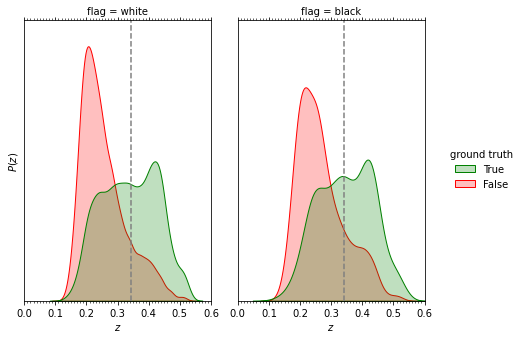

In [14]:
data_ = pd.DataFrame({'x': y_scores_all, 'ground truth': y_test_all, 'flag': np.where(s_test_all, 'black', 'white')})
g = sns.displot(
    data=data_, x='x', hue='ground truth', col='flag', kind='kde', hue_order=[True, False], palette=['green', 'red'], common_norm=False, fill=True, height=4.82, aspect=2/3, 
    facet_kws={'despine': False, 'xlim': (0, .6)}
)
# sns.despine(top=False, right=False)
g.refline(x=threshold)
g.set_axis_labels(r'$z$', r'$P(z)$')
g.set_yticklabels([])
g.set(yticks=[])
g.axes[0][0].xaxis.set_minor_locator(MultipleLocator(.01))
g.axes[0][0].xaxis.set_ticks_position('both')
g.axes[0][1].xaxis.set_ticks_position('both')
plt.savefig('fig/score-pdf.pdf')

In [15]:
objs = [
    pd.crosstab(pd.Series(y_test_all[s_test_all], name='Actual'), pd.Series(y_pred_all[s_test_all], name='Predicted')),
    pd.crosstab(pd.Series(y_test_all[~s_test_all], name='Actual'), pd.Series(y_pred_all[~s_test_all], name='Predicted'))      
]
pd.concat(objs, axis=1, keys=['black', 'white'], names=['flag'])

flag      black       white      
Predicted False True  False  True
Actual                           
False      1101  233  16293  2526
True        136  143   2623  2519

# Determine fairness measures with prior threshold

In [16]:
values = [np.around(ortho, 1) for ortho in np.linspace(0, 1, 11)]
iterator = [(ortho, fold) for ortho in values for fold in range(5)]

y_scores_all = {np.around(orthogonality, 1): [] for orthogonality in values}
y_test_all = {np.around(orthogonality, 1): [] for orthogonality in values}
s_test_all = {np.around(orthogonality, 1): [] for orthogonality in values}
y_pred_all = {np.around(orthogonality, 1): [] for orthogonality in values}
fairness_measures = list()

for ortho, fold in tqdm(iterator):  
    best_params_ = best_params.loc[lambda x: (x.orthogonality.round(1) == ortho) & (x.outer_fold == fold)].iloc[0]
    max_depth = int(best_params_['max_depth'])
    n_bins = int(best_params_['n_bins'])
    filepath = f'{cache_dir}/{max_depth}-{ortho:.2f}-{n_bins}-{fold}.npy'
    y_score = np.load(filepath)
    
    _, (_, test_idx) = outer_folds[fold]
    assert len(y_score) == len(test_idx)
    
    y_test = y[test_idx]
    s_test = s[test_idx]
    
    # FLIPPING!!!
    y_scores_all[ortho].extend(1-y_score)
    y_test_all[ortho].extend(~y_test)
    s_test_all[ortho].extend(s_test)

for ortho in values:
    y_score = np.array(y_scores_all[ortho])
    y_test = np.array(y_test_all[ortho])
    s_test = np.array(s_test_all[ortho])
    threshold = np.quantile(y_scores_all[ortho], np.mean(~y_test))

    y_pred = y_score > threshold
    ppr_w = y_pred[~s_test].mean()
    ppr_b = y_pred[s_test].mean()

    fpr_w = (y_score > threshold)[~y_test & ~s_test].mean()
    fpr_b = (y_score > threshold)[~y_test & s_test].mean()
    tpr_w = (y_score > threshold)[y_test & ~s_test].mean()
    tpr_b = (y_score > threshold)[y_test & s_test].mean()

    fairness_measures.append(
        {
            'orthogonality': ortho,
            'positive prediction rate (white)': ppr_w,
            'positive prediction rate (black)': ppr_b,
            'false positive rate (white)': fpr_w,
            'false positive rate (black)': fpr_b,
            'true positive rate (white)': tpr_w,
            'true positive rate (black)': tpr_b
        }
    )
fairness_measures = pd.DataFrame(fairness_measures)

  0%|          | 0/55 [00:00<?, ?it/s]

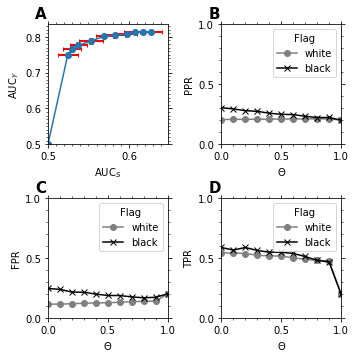

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(4.82,4.82), constrained_layout=True)
ax1.errorbar(data=total_performance, x='auc_s', y='auc_y', xerr='auc_s_std', yerr='auc_y_std', ecolor='red', elinewidth=2, capsize=2, marker='o')
ax1.set_xlim(.5)
ax1.set_ylim(.5)
ax1.set_xlabel(r'$\mathrm{AUC}_S$')
ax1.set_ylabel(r'$\mathrm{AUC}_Y$')
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_major_locator(MultipleLocator(.1))
ax1.yaxis.set_major_locator(MultipleLocator(.1))
ax1.xaxis.set_minor_locator(MultipleLocator(.01))
ax1.yaxis.set_minor_locator(MultipleLocator(.01))
ax1.set_box_aspect(1)
ax1.text(-.11, 1.05, 'A', transform=ax1.transAxes, size=15, weight='bold')

ax2.plot('orthogonality', 'positive prediction rate (white)', data=fairness_measures, marker='o', color='grey', label='white')
ax2.plot('orthogonality', 'positive prediction rate (black)', data=fairness_measures, marker='x', color='black', label='black')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlabel(r'$\Theta$')
ax2.set_ylabel('PPR')
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_major_locator(MultipleLocator(.5))
ax2.yaxis.set_major_locator(MultipleLocator(.5))
ax2.xaxis.set_minor_locator(MultipleLocator(.1))
ax2.yaxis.set_minor_locator(MultipleLocator(.1))
ax2.legend(title='Flag', loc='upper right')
ax2.set_box_aspect(1)
ax2.text(-.11, 1.05, 'B', transform=ax2.transAxes, size=15, weight='bold')

ax3.plot('orthogonality', 'false positive rate (white)', data=fairness_measures, marker='o', color='grey', label='white')
ax3.plot('orthogonality', 'false positive rate (black)', data=fairness_measures, marker='x', color='black', label='black')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.set_xlabel(r'$\Theta$')
ax3.set_ylabel('FPR')
ax3.xaxis.set_ticks_position('both')
ax3.yaxis.set_ticks_position('both')
ax3.xaxis.set_major_locator(MultipleLocator(.5))
ax3.yaxis.set_major_locator(MultipleLocator(.5))
ax3.xaxis.set_minor_locator(MultipleLocator(.1))
ax3.yaxis.set_minor_locator(MultipleLocator(.1))
ax3.legend(title='Flag', loc='upper right')
ax3.set_box_aspect(1)
ax3.text(-.11, 1.05, 'C', transform=ax3.transAxes, size=15, weight='bold')

ax4.plot('orthogonality', 'true positive rate (white)', data=fairness_measures, marker='o', color='grey', label='white')
ax4.plot('orthogonality', 'true positive rate (black)', data=fairness_measures, marker='x', color='black', label='black')
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.set_xlabel(r'$\Theta$')
ax4.set_ylabel('TPR')
ax4.xaxis.set_ticks_position('both')
ax4.yaxis.set_ticks_position('both')
ax4.xaxis.set_major_locator(MultipleLocator(.5))
ax4.yaxis.set_major_locator(MultipleLocator(.5))
ax4.xaxis.set_minor_locator(MultipleLocator(.1))
ax4.yaxis.set_minor_locator(MultipleLocator(.1))
ax4.legend(title='Flag', loc='upper right')
ax4.set_box_aspect(1)
ax4.text(-.11, 1.05, 'D', transform=ax4.transAxes, size=15, weight='bold')
fig.savefig('fig/fairness.pdf')

# Fairness measures for different $\Theta$ and thresholds

In [18]:
best_params.loc[lambda x: (x.orthogonality == 0) & (x.outer_fold == 0)].iloc[0]

orthogonality    0.0
outer_fold       0.0
max_depth        6.0
n_bins           2.0
Name: 5, dtype: float64

In [19]:
values = [.1, .3, .5, .7, .9]
iterator = [
    (orthogonality, threshold_quantile, fold) 
    for orthogonality in values 
    for threshold_quantile in values 
    for fold in range(5)
]

y_scores_all = dict()
y_test_all = dict()
s_test_all = dict()
thresholds = dict()
y_pred_all = dict()
fairness_measures = list()

for orthogonality in values:
    for threshold_quantile in values:      
        y_scores_all[(orthogonality, threshold_quantile)] = list()
        y_test_all[(orthogonality, threshold_quantile)] = list()
        s_test_all[(orthogonality, threshold_quantile)] = list()

for ortho, threshold_quantile, fold in tqdm(iterator):    
    best_params_ = best_params.loc[lambda x: (x.orthogonality.round(1) == ortho) & (x.outer_fold == fold)].iloc[0]
    max_depth = int(best_params_['max_depth'])
    n_bins = int(best_params_['n_bins'])
    filepath = f'{cache_dir}/{max_depth}-{ortho:.2f}-{n_bins}-{fold}.npy'
    y_score = np.load(filepath)
    
    _, (_, test_idx) = outer_folds[fold]
    assert len(y_score) == len(test_idx)
    
    y_test = y[test_idx]
    s_test = s[test_idx]
    assert len(y_score) == len(y_test)
    assert len(s_test) == len(y_score)
    
    # FLIPPING!!!
    y_scores_all[(ortho, threshold_quantile)].extend(1-y_score)
    y_test_all[(ortho, threshold_quantile)].extend(~y_test)
    
    s_test_all[(ortho, threshold_quantile)].extend(s_test)

for orthogonality in values:
    for threshold_quantile in values: 
        i = (orthogonality, threshold_quantile)
        y_score = np.array(y_scores_all[i])
        y_test = np.array(y_test_all[i])
        s_test = np.array(s_test_all[i])
        threshold = np.quantile(y_scores_all[i], threshold_quantile)
        
        y_pred = y_score > threshold
        ppr_w = y_pred[~s_test].mean()
        ppr_b = y_pred[s_test].mean()
        
        fpr_w = (y_score > threshold)[~y_test & ~s_test].mean()
        fpr_b = (y_score > threshold)[~y_test & s_test].mean()
        tpr_w = (y_score > threshold)[y_test & ~s_test].mean()
        tpr_b = (y_score > threshold)[y_test & s_test].mean()
        
        fairness_measures.append(
            {
                'orthogonality': orthogonality,
                'threshold quantile': threshold_quantile,
                'disparate impact': 1 - (ppr_w / ppr_b),
                'equalized odds': max(abs(fpr_w - fpr_b), abs(tpr_w - tpr_b))
            }
        )
fairness_measures = pd.DataFrame(fairness_measures)

  0%|          | 0/125 [00:00<?, ?it/s]

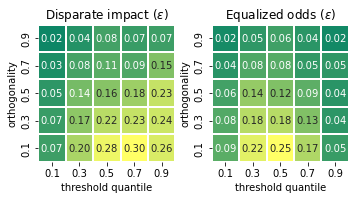

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.82, 4.82*(2/3)), constrained_layout=True)

disparate_impact = fairness_measures.pivot('orthogonality', 'threshold quantile', 'disparate impact').sort_index(ascending=False)
equalized_odds = fairness_measures.pivot('orthogonality', 'threshold quantile', 'equalized odds').sort_index(ascending=False)

ax1.set_title(r"Disparate impact ($\epsilon$)")
sns.heatmap(disparate_impact, vmin=0, square=True, annot=True, fmt='.2f', linewidths=.1, cmap='summer', cbar=False, ax=ax1)

ax2.set_title(r"Equalized odds ($\epsilon$)")
sns.heatmap(equalized_odds, vmin=0, square=True, annot=True, fmt='.2f', linewidths=.1, cmap='summer', cbar = False, ax=ax2)
fig.savefig('fig/fairness-measures.pdf')